In [2]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_sheet
from peripodial.anisotropy import angle_distribution

vispy  won't work


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


Text(0, 0.5, 'D-V axis')

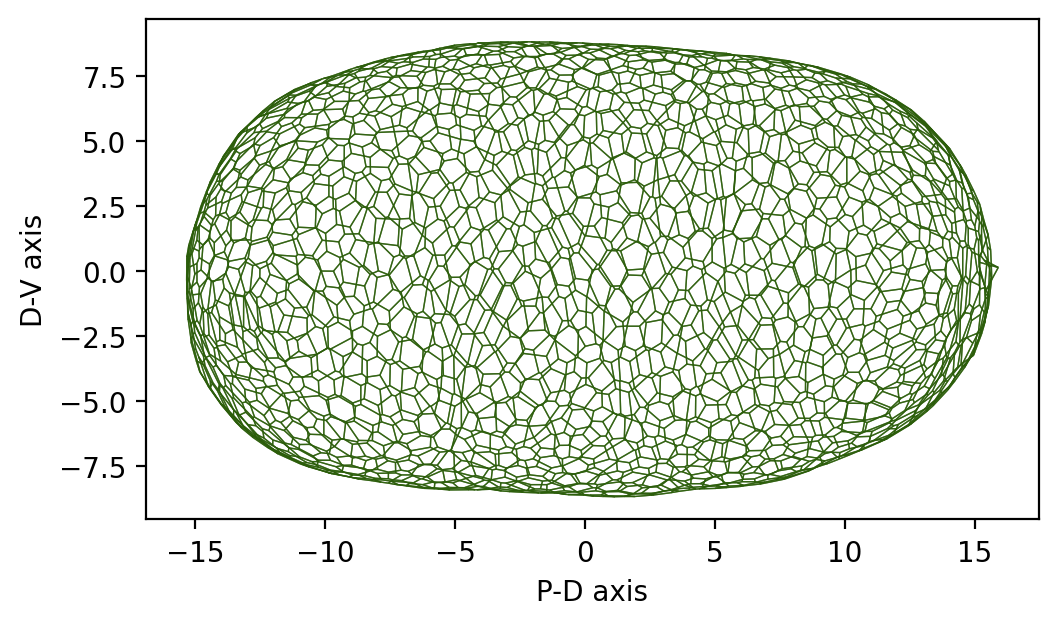

In [5]:
fig, ax = sheet_view(sheet, coords=["z", "x"])
ax.set_xlabel('P-D axis')
ax.set_ylabel('D-V axis')


In [6]:
sheet.face_df["area"].mean()

0.9786486131546664

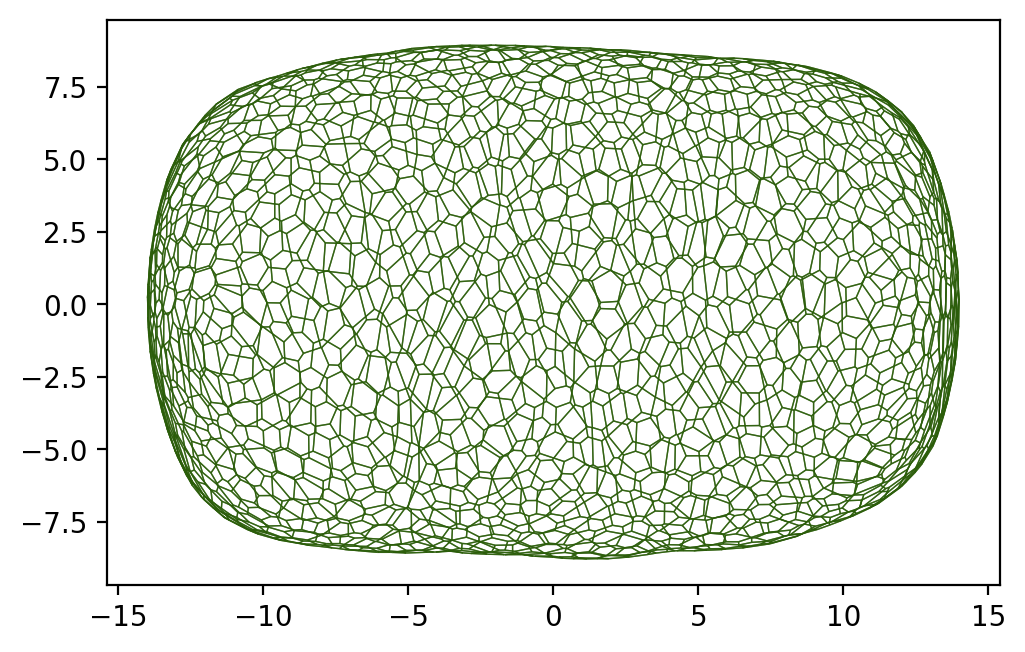

In [7]:
specs['settings']["barrier_radius"] = 14
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [8]:
#### verify that the function update_weight works
"""change = []
sheet_copy = sheet.copy()
theta = np.pi / 3

for i in range(10): 
    
    print(f"{i+1} / 10", end=" ")
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1.0,
    )
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)


sheet_copy1 = sheet_copy.copy()
sheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] 

draw_specs = {'vert': {
            'visible': False
            },
        'edge': {
            'color': sheet_copy1.edge_df["weight"],
            'colormap': "coolwarm",
            'width': sheet_copy1.edge_df["weight"]
            #'zorder': depth.values
            }
        }

fig, ax = sheet_view(sheet_copy1, ["z", "x"], mode='2D', **draw_specs)
ax.set_facecolor('#101010')
print(change)"""


'change = []\nsheet_copy = sheet.copy()\ntheta = np.pi / 3\n\nfor i in range(10): \n    \n    print(f"{i+1} / 10", end=" ")\n    z_orientation = update_weights(\n        sheet_copy, \n        threshold_angle=theta, \n        below_threshold=0.5,\n        above_threshold=1.0,\n    )\n    solver = QSSolver(with_t1=False, with_t3=False)\n    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})\n    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)\n\n\nsheet_copy1 = sheet_copy.copy()\nsheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] \n\ndraw_specs = {\'vert\': {\n            \'visible\': False\n            },\n        \'edge\': {\n            \'color\': sheet_copy1.edge_df["weight"],\n            \'colormap\': "coolwarm",\n            \'width\': sheet_copy1.edge_df["weight"]\n            #\'zorder\': depth.values\n            }\n        }\n\nfig, ax = sheet_view(sheet_copy1, ["z", "x"], mode=\'2D\', **draw_specs)\nax.set_fac

In [9]:
aniso(sheet, coords = ['x','y','z'])

face
0       0.169058
1       0.295585
2       0.250872
3       0.192814
4       0.311998
          ...   
1647    0.458869
1648    0.147619
1649    0.282269
1650    0.194805
1651    0.076782
Name: anisotropy, Length: 1652, dtype: float64

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


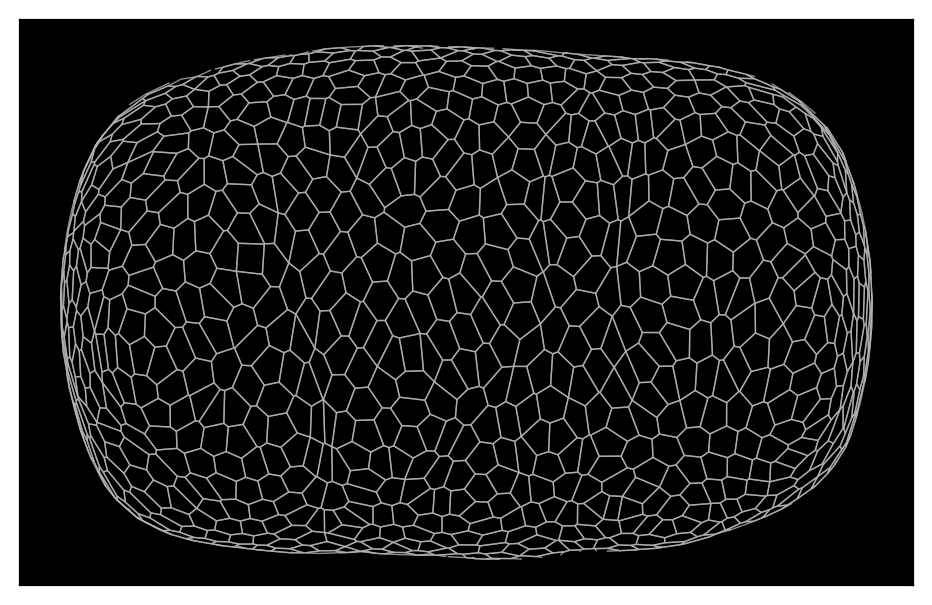

In [10]:
fig, ax = draw_half_sheet(sheet, ax=None)
ax.set_facecolor("black")

In [11]:
sheets_obj = {}
aniso_cell_values_d = []
angle_vs = []
theta = np.pi / 3
bts = np.arange(1, 0.3, -0.1)
angle_vs = []

for i, below_threshold in enumerate(bts):
    
    print(f"{i+1} / {7}", end=" ")
    z_orientation = update_weights(
        sheet, 
        threshold_angle=theta, 
        below_threshold=below_threshold,
        above_threshold=1,
    )
    geom.update_all(sheet)
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    angle_v = np.arcsin(z_orientation)
    angle_degrees = np.degrees(angle_v)
    sheet.face_df['anisotropy'] = aniso(sheet, coords = ['x','y','z'])
    center = np.abs(sheet.face_df["z"]) < sheet.face_df["z"].max()*0.75
    aniso_cell = sheet.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    angle_vs.append(angle_degrees)
    sheet_copy = sheet.copy()
    sheets_obj[below_threshold] = sheet_copy




print(angle_degrees)


1 / 7 2 / 7 3 / 7 4 / 7 5 / 7 6 / 7 7 / 7 edge
0       51.101449
1       87.733880
2       21.339314
3       66.056163
4       12.924065
          ...    
9895    48.401472
9896    56.060913
9897    56.060913
9898     3.693378
9899     3.693378
Length: 9900, dtype: float64


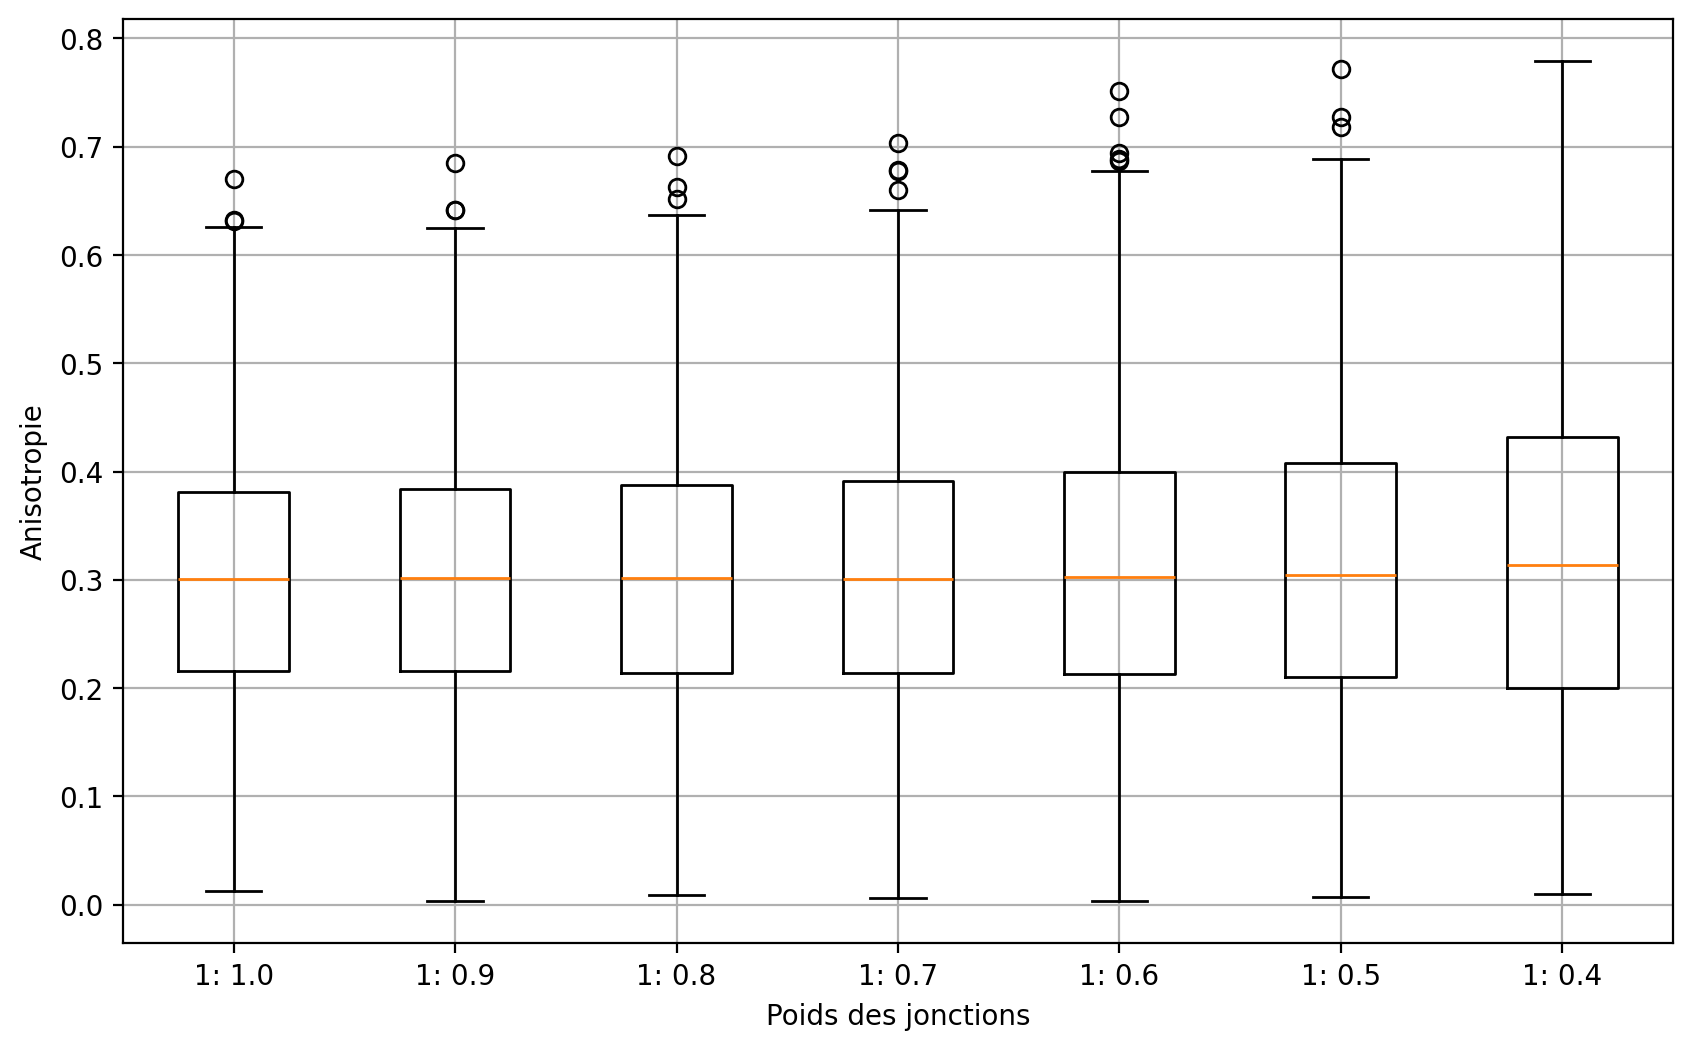

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, ttest_ind

# graphique
plt.figure(figsize=(10, 6))
bp = plt.boxplot(aniso_cell_values_d, patch_artist=False)
plt.xlabel('Poids des jonctions')
plt.ylabel('Anisotropie')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['1: {:.1f}'.format(i) for i in bts])
plt.grid(True)

plt.savefig('../image/plot_aniso_x_position.png', transparent=False)
plt.show()


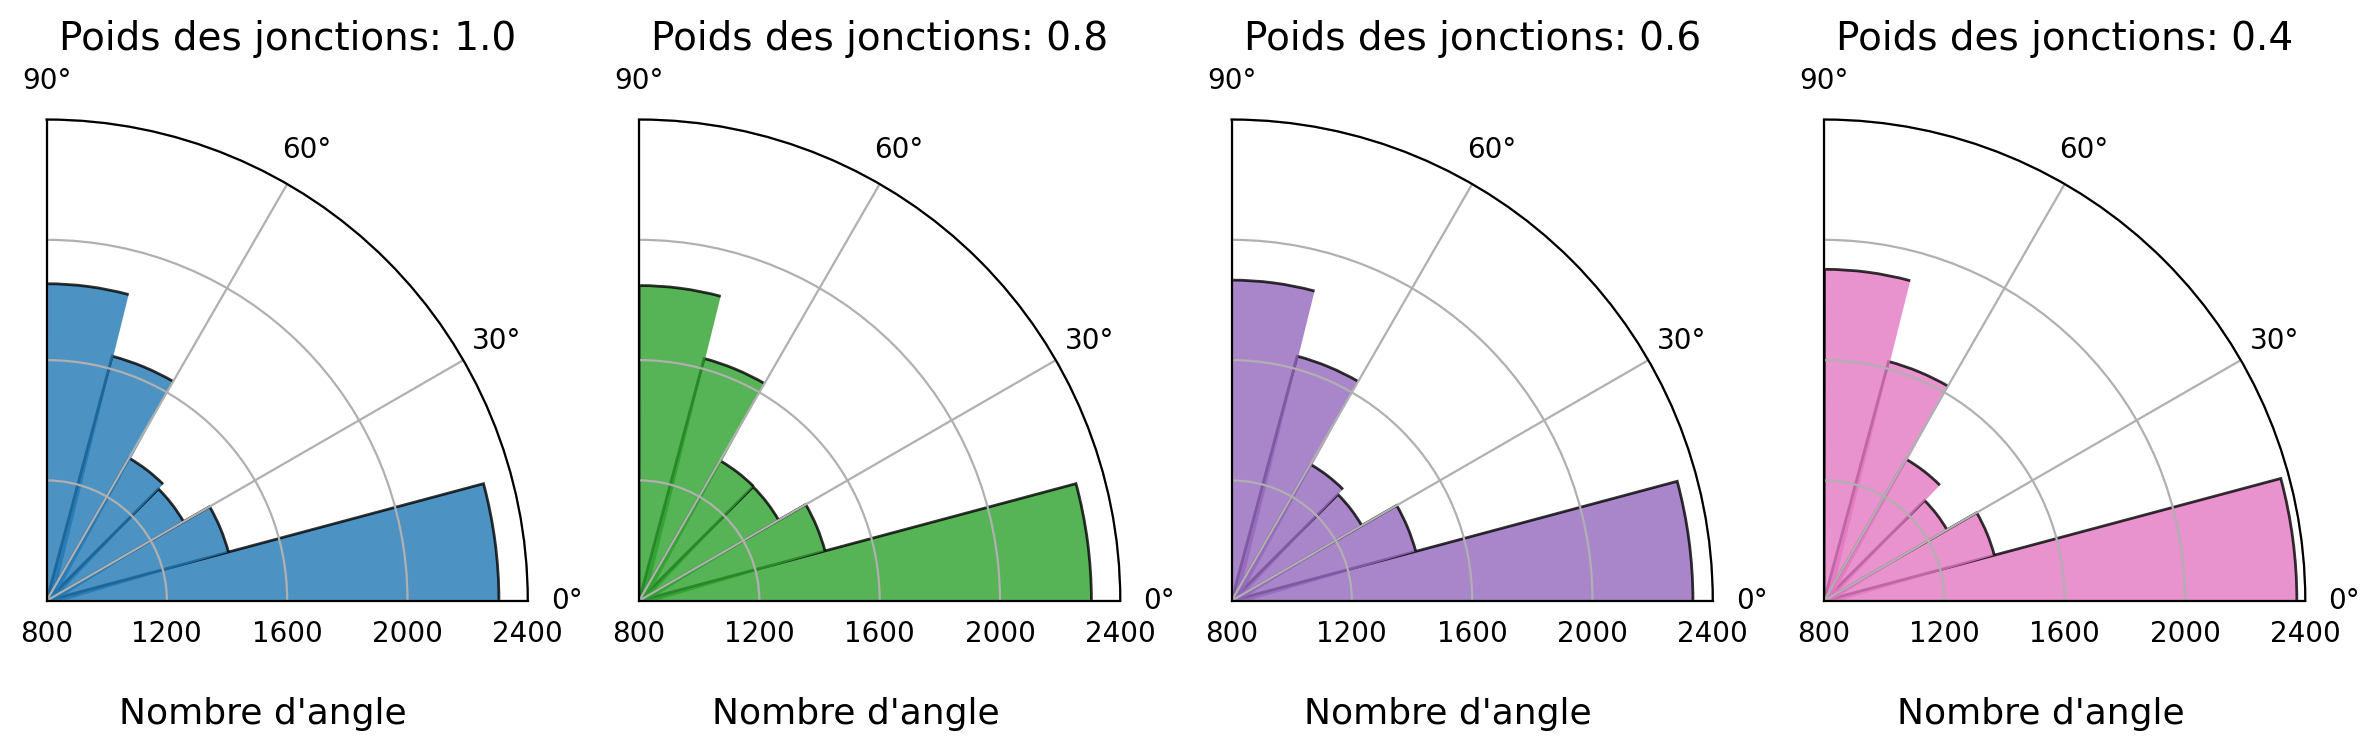

In [72]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, (len(angle_vs) + 1) // 2, figsize=(12, 4), subplot_kw=dict(polar=True))

# Itérer sur les objets
for i in range(0, len(angle_vs), 2):
    data = angle_vs[i]
    ax = axs[i // 2]
    ax.hist(np.radians(data), bins=6, color='C{}'.format(i), alpha=0.8, edgecolor='black')
    ax.set_title('Poids des jonctions: {:.1f}'.format(bts[i]), fontsize=14)
    ax.set_xlim(0, np.pi / 2)
    ax.set_ylim(800, 2400)
    ax.set_yticks([800, 1200, 1600, 2000, 2400])  # Définir les positions des marqueurs sur l'axe y
    ax.set_yticklabels(['800', '1200', '1600', '2000', '2400'])  # Définir les étiquettes correspondantes
    ax.set_xlabel("Nombre d'angle", fontsize=13)
    ax.xaxis.set_label_coords(0.45, -0.2)
plt.tight_layout()

plt.savefig('../image/plot_distribution_angle.png', transparent=False)

# Affichage
plt.show()


/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


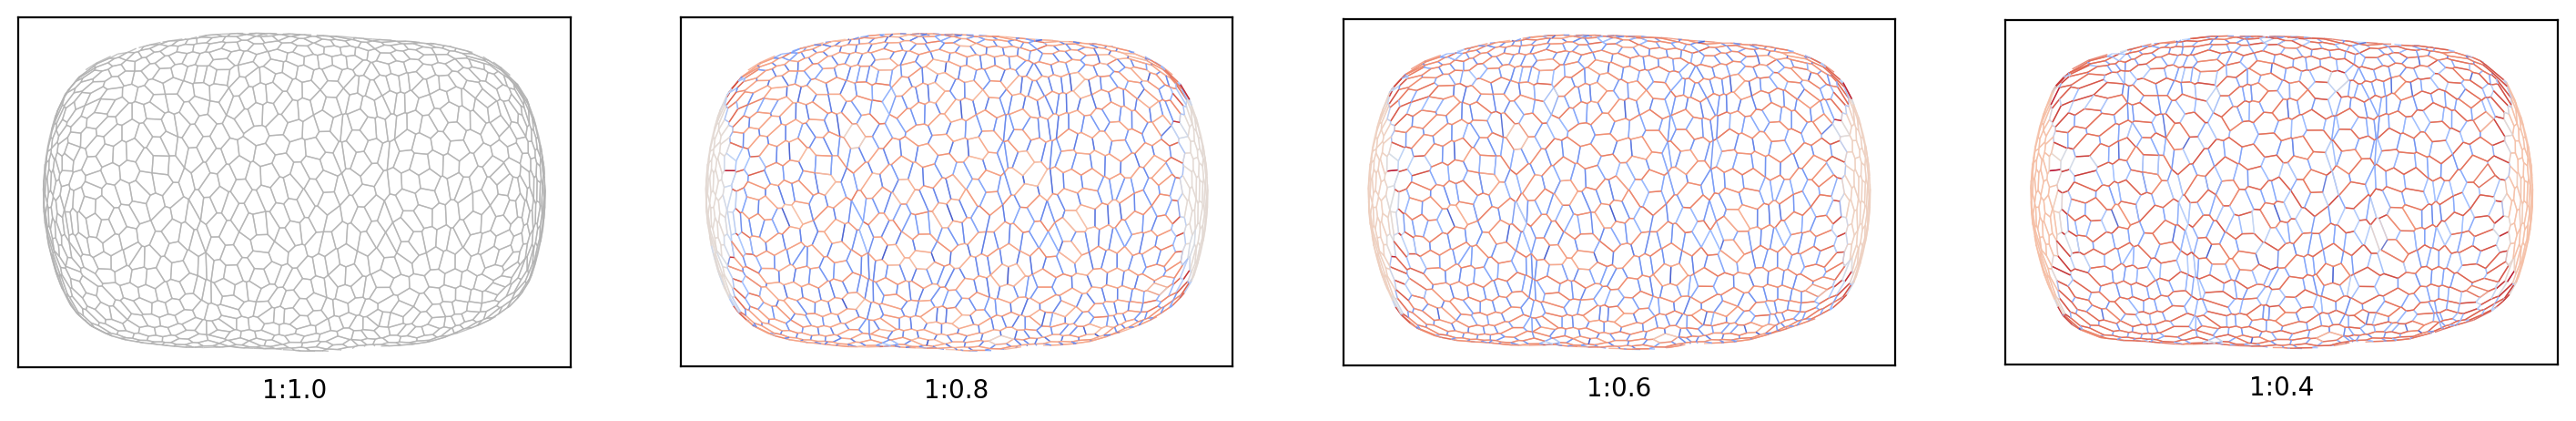

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, (len(sheets_obj) + 1) // 2, figsize=(28, 8))

for i, (above_threshold, sheet_copy) in enumerate(sheets_obj.items()):
    if i % 2 == 0: 
        ax = axes[i // 2]
        fig, ax = draw_half_sheet(sheet_copy, ax)
        ax.set_xlabel('1:{:.1f}'.format(bts[i]))
        ax.set_facecolor("white")

fig.set_size_inches(18, 5)
plt.savefig('../image/aniso_weight.png', transparent=False)
plt.show()



In [ ]:
"""from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/polarity.hdf5",sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/polarity.json", overwrite=True)"""